In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
train = pd.read_csv("split/train.csv")
dev = pd.read_csv("split/dev.csv")
test = pd.read_csv("split/test.csv")

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
TEXT = "aliased_snippet"
RESULT = "is_parent"
COMPANY1= "company1"
COMPANY2 = "company2"

In [99]:
onto_test = pd.read_csv("./processed/test.csv")

In [101]:
corpus = train[TEXT].append(dev[TEXT]).append(test[TEXT]).append(onto_test[TEXT])
corpus.shape

(99974,)

In [103]:
num_words = 39000
max_len = 40

In [104]:
tokenizer  = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(corpus)

In [105]:
def tokenize(data):
    tokenized = tokenizer.texts_to_sequences(data[TEXT])
    tokenized = pad_sequences(tokenized,maxlen=max_len)
    return tokenized

In [106]:
train_tokenized = tokenize(train)

In [107]:
train_tokenized.shape, train_tokenized[0]

((55568, 40),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  137,   23,
           2, 1159,   19,    3,  106,   85, 1006,  137,   23,    2, 1159,
          19,    3,  106,   85, 1006,    2,    5], dtype=int32))

In [108]:
dev_tokenized = tokenize(dev)

In [109]:
dev_tokenized.shape

(15876, 40)

In [110]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, Bidirectional, GlobalMaxPooling1D, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [209]:
model = Sequential([
    Embedding(num_words,128, input_length=train_tokenized.shape[1]),
    Bidirectional(LSTM(200, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.4),
    Dense(16, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

In [210]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 40, 128)           4992000   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 40, 400)           526400    
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 400)               0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               51328     
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 16)                2064      
__________

In [211]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [212]:
early_stoping = EarlyStopping(patience=2)

In [213]:
checkpoint = ModelCheckpoint(filepath="./models/bi_lstm.h5", save_best_only=True)

In [214]:
model.fit(train_tokenized, train[RESULT],validation_data=(dev_tokenized, dev[RESULT]), batch_size=64, epochs=10, callbacks=[early_stoping, checkpoint])

Train on 55568 samples, validate on 15876 samples
Epoch 1/10
55568/55568 [==============================] - 91s 2ms/step - loss: 0.4989 - acc: 0.7564 - val_loss: 0.3962 - val_acc: 0.8246
Epoch 2/10
55568/55568 [==============================] - 84s 2ms/step - loss: 0.2953 - acc: 0.8804 - val_loss: 0.3292 - val_acc: 0.8639
Epoch 3/10
55568/55568 [==============================] - 84s 2ms/step - loss: 0.1727 - acc: 0.9368 - val_loss: 0.3358 - val_acc: 0.8701
Epoch 4/10
55568/55568 [==============================] - 84s 2ms/step - loss: 0.1026 - acc: 0.9633 - val_loss: 0.4254 - val_acc: 0.8724


The result above is result of many small parameter changes and tuning in the network and training with smaller batch gived better results due to smaller gradient I suppose.

In [140]:
test_tokenized = tokenize(test)
test_tokenized.shape

(7939, 40)

In [141]:
from keras.models import load_model

In [142]:
from sklearn.metrics import f1_score

In [165]:
def score_model(model):
    predictions = model.predict(test_tokenized)    
    predictions_binary = np.round(predictions)
    plot_confusion_matrix(test[RESULT], predictions_binary,classes=[0,1], normalize=True) 
    print("F1 score of test is {}".format(f1_score(test[RESULT], predictions_binary)))    

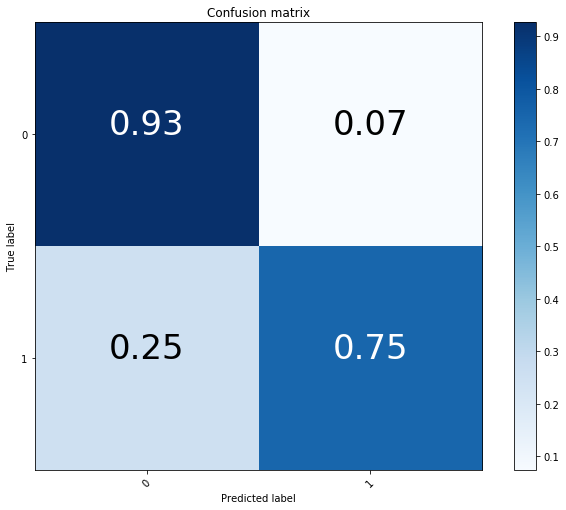

F1 score of test is 0.7798326728313519


In [218]:
score_model(model)

In [219]:
model.save("models/bi_lstm_100_200_779f1.h5")

In [175]:
onto_test.shape

(20591, 5)

In [176]:
onto_test[:5]

,company1,company2,is_parent,snippet,aliased_snippet
0,Ford_Motor_Company,Holden,NaN,95s to top the sheets ahead of Kiwi Fabian Cou...,95s to top the sheets ahead of kiwi fabian cou...
1,Ford_Motor_Company,Holden,NaN,95s to top the sheets ahead of Kiwi Fabian Cou...,95s to top the sheets ahead of kiwi fabian cou...
2,Apple_Inc.,HBO,NaN,\nGamers who want to access HBO Now on the Xbo...,\ngamers who want to access company2 now on ...
3,Apple_Inc.,HBO,NaN,\nHBO first launched its standalone subscripti...,\n company2 first launched its standalone sub...
4,Apple_Inc.,HBO,NaN,\nHBO first launched its standalone subscripti...,\n company2 first launched its standalone sub...


In [177]:
onto_test_tokenized = tokenize(onto_test)

In [163]:
%mkdir onto-test

In [220]:
def predict_onto(model, save_name):
    pred = model.predict(onto_test_tokenized)
    onto_test[RESULT] = pred
    onto_test.to_csv("./onto-test/"+save_name)

This is the best model for lstm so far that's why I will save the test result for eval

In [221]:
predict_onto(model, "bi_lstm.csv")

In [222]:
def show_onto(save_name):
    return pd.read_csv("./onto-test/"+save_name)

In [223]:
pred = show_onto("bi_lstm.csv")

In [224]:
pred[pred["company1"] == "Danaher_Corporation"]

,Unnamed: 0,company1,company2,is_parent,snippet,aliased_snippet
311,311,Danaher_Corporation,Pall_Corporation,0.998655,Pall_Corporation is being acquired by Danaher...,company2 is being acquired by company1 ( ...


### Whats next?
The code above was just to clarify everything works as aspected, now lets expolore if adding some CNN filters will improve the score. My hipotesis is by adding convolutions the model will be able to filter only the most useful features and will improve the score above

In [39]:
from keras.layers import Convolution1D,MaxPooling1D, GlobalAveragePooling1D,Flatten, AveragePooling1D
from keras.regularizers import l1,l2

In [246]:
model = Sequential([
    Embedding(num_words,128, input_length=train_tokenized.shape[1]),
    Convolution1D(50, kernel_size=2, padding="same", activation="relu"),
    MaxPooling1D(pool_size=3),
    Convolution1D(50, kernel_size=3, padding="same", activation="relu"),
    MaxPooling1D(),
    Dropout(0.3),
    Bidirectional(LSTM(200, return_sequences=True)),
    GlobalAveragePooling1D(),
    Dense(64, activation="relu"),
    Dro
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

In [245]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 40, 128)           4992000   
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 40, 50)            12850     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 13, 50)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 13, 50)            7550      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 6, 50)             0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 6, 50)             0         
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 6, 400)            401600    
__________

In [241]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [242]:
checkpoint = ModelCheckpoint(filepath="./models/conv_bi_lstm.h5", save_best_only=True)

In [243]:
model.fit(train_tokenized, train[RESULT],validation_data=(dev_tokenized, dev[RESULT]), batch_size=64, epochs=10, callbacks=[early_stoping, checkpoint])

Train on 55568 samples, validate on 15876 samples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[39000,128]
	 [[Node: training_27/Adam/mul_2 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_27/Adam/sub_2, training_27/Adam/mul_2/y)]]

Caused by op 'training_27/Adam/mul_2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-243-eaf8b1a7de89>", line 1, in <module>
    model.fit(train_tokenized, train[RESULT],validation_data=(dev_tokenized, dev[RESULT]), batch_size=64, epochs=10, callbacks=[early_stoping, checkpoint])
  File "/usr/local/lib/python3.5/dist-packages/keras/models.py", line 960, in fit
    validation_steps=validation_steps)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/training.py", line 1634, in fit
    self._make_train_function()
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/usr/local/lib/python3.5/dist-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/optimizers.py", line 432, in get_updates
    m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py", line 894, in binary_op_wrapper
    return func(x, y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py", line 1117, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 2726, in _mul
    "Mul", x=x, y=y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[39000,128]
	 [[Node: training_27/Adam/mul_2 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_27/Adam/sub_2, training_27/Adam/mul_2/y)]]


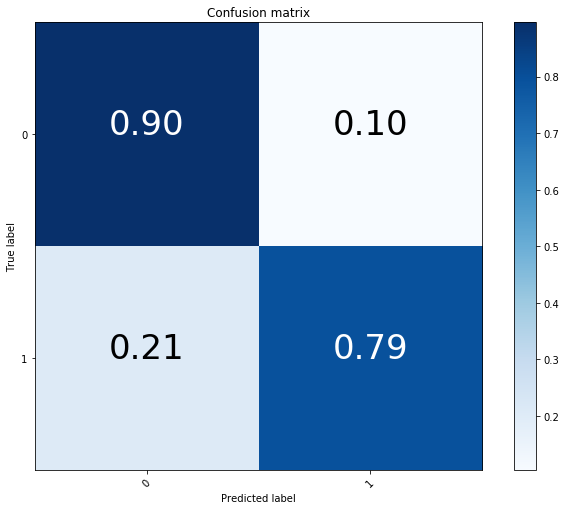

F1 score of test is 0.7788381742738589


In [68]:
score_model(model)